# Implementation

## Import libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Add activation functions

In [52]:
def sigmoid(x, derivative=False):
    if derivative:
        return np.exp(x) / ((1 + np.exp(x)) ** 2)
    return 1/(1+np.exp(-x))

def linear(x, derivative=False):
    if derivative:
        return np.ones(x.shape)
    return x

def softmax(x, derivative=False):
    if derivative:
        return -np.e**x / (np.sum(np.e**x, axis=0) ** 2)
    return np.e**x / np.sum(np.e**x, axis=0)

def tanh(x, derivative=False):
    e2x = (np.exp(2*x))
    if derivative:
        return (e2x * 4) / ((e2x + 1) ** 2)
    return (e2x - 1) / (e2x + 1)

def relu(x, derivative=False):
    if derivative:
        return np.maximum(np.sign(x) * x / x, 0)
    return np.maximum(x, 0)

## Initialize weights

In [53]:
def init_weights(neurons_in, neurons_out, init_method='Xavier'):
    if init_method == 'zeros':
        weights = np.zeros([neurons_out, neurons_in])
        bias = np.zeros([neurons_out,1])
    elif init_method == 'uniform':
        weights = np.random.uniform(0,1, (neurons_out, neurons_in))
        bias = np.random.uniform(0,1,(neurons_out,1))
    elif init_method == 'Xavier':
        weights = np.random.randn(neurons_out, neurons_in)*np.sqrt(1/(neurons_in))
        bias = np.random.randn(neurons_out,1)*np.sqrt(1/(neurons_in))
    elif init_method == "He":
        weights = np.random.randn(neurons_out, neurons_in)*np.sqrt(2/(neurons_in+neurons_out)) 
        bias = np.random.randn(neurons_out,1)*np.sqrt(2/(neurons_in+neurons_out))
    return weights, bias

## Define measures

In [54]:
def MSE(x, y):
    return np.mean((x - y) ** 2)

def accuracy(y_pred, y):
    return np.sum(y.T==y_pred)/y.shape[0]

## Prepare data

In [55]:
def scale(X):
    return (X-np.mean(X, 0))/np.std(X, 0)

def split_data(data, input_colums):
    x = data[:, 0:input_colums] # inputs
    y = data[:, input_colums:(input_colums+1)] # outputs
    return x,y

def read_data(file, classification=False):
    data = np.genfromtxt(file, delimiter=',')
    if not classification:
        data = data[1:, 1:]
    else:
        data = data[1:, :]
    return data

def one_hot_encode(y):
    y = pd.DataFrame(y)
    y = pd.get_dummies(y[0])
    return np.array(y)

def shuffle_batch(x, y):
    t = np.arange(x.shape[0])
    np.random.shuffle(t)
    return x[t], y[t]

## Layer class

In [65]:
class Layer:
    def __init__(self, neurons_in, neurons_out, activ_function, init_method):
        self.neurons_in = neurons_in
        self.neurons_out = neurons_out
        self.activ_function = activ_function
        self.weights, self.bias = init_weights(neurons_in, neurons_out, init_method)

        self.momentum_weights = np.zeros([neurons_out, neurons_in])
        self.momentum_bias = np.zeros([neurons_out,1])
        self.grad_squared_weights = np.zeros([neurons_out, neurons_in])
        self.grad_squared_bias = np.zeros([neurons_out,1])
    
    def forward(self, x):
        self.forward_linear = self.weights @ x + self.bias
        return self.activ_function(self.forward_linear)

    def backpropagate_last_layer(self, y, y_pred):
        self.forward_gradient = self.activ_function(self.forward_linear, derivative=True)
        if self.activ_function != softmax:
            self.backward_error = (y_pred.T - y.T) * self.forward_gradient
        else:
            ex = np.exp(self.forward_linear)
            sum_ex = np.sum(ex, axis=0)
            gradient = sum_ex * ex / (sum_ex) ** 2
            self.backward_error = (y_pred.T-y.T) * gradient
            for i in range(self.forward_linear.shape[0]):
                self.backward_error[i, :] += np.sum((y_pred.T-y.T) * self.forward_gradient, axis=0) * ex[i, :]

    def backpropagate_layer(self, error_weight):
        self.forward_gradient = self.activ_function(self.forward_linear, derivative=True)
        self.backward_error = error_weight.T * self.forward_gradient

    def error_weight(self):
        return self.backward_error.T @ self.weights

    def update_weights(self, previous_predict, alpha, beta, gradient_method):
        d_weights = self.backward_error @ previous_predict.T
        d_bias = np.sum(self.backward_error)

        if gradient_method == 'gradient_descent':
            self.weights = self.weights - alpha * d_weights
            self.bias = self.bias - alpha * d_bias

        elif gradient_method == 'momentum':
            self.momentum_weights = d_weights + beta * self.momentum_weights
            self.momentum_bias = d_bias + beta * self.momentum_bias 
            
            self.weights = self.weights - alpha * self.momentum_weights
            self.bias = self.bias - alpha * self.momentum_bias

        elif gradient_method == 'rms':
            self.grad_squared_weights = beta * (d_weights * d_weights) + (1 - beta) * self.grad_squared_weights 
            self.grad_squared_bias = beta * (d_bias * d_bias) + (1 - beta) * self.grad_squared_bias 
            
            self.weights = self.weights - alpha * d_weights / (np.sqrt(self.grad_squared_weights) + np.ones(self.grad_squared_weights.shape) * 10 **(-6))
            self.bias = self.bias - alpha * d_bias / (np.sqrt(self.grad_squared_bias) + np.ones(self.grad_squared_bias.shape) * 10 **(-6))
   

## Neural Network class

In [57]:
class NeuralNetwork:
    def __init__(self, neurons, activ_function, last_activ, init_method='zeros'):

        self.layers = []
        for i in range(len(neurons)-2):
            self.layers.append(Layer(neurons[i], neurons[i+1], activ_function, init_method))
        self.layers.append(Layer(neurons[i+1], neurons[i+2], last_activ, init_method))
        self.predictions = []

    def forward(self, x):
        self.predictions = []
        x = x.T
        for i in range(len(self.layers)):
            x = self.layers[i].forward(x)
            self.predictions.append(x)
        return x.T

    def backpropagate(self, x, y, alpha=0.001, batch_size=50, n_epochs=1, beta=0.5, gradient_method='gradient_descent'):
        n_batches = math.ceil(x.shape[0]/batch_size)
        for j in range(n_epochs):
            x, y = shuffle_batch(x, y)
            for i in range(n_batches):
                self.backpropagate_batch(x[i*batch_size:(i+1)*batch_size, :], y[i*batch_size:(i+1)*batch_size, :], alpha, beta, gradient_method)

    def backpropagate_batch(self, x, y, alpha, beta, gradient_method):
        y_pred = self.forward(x)
        self.layers[-1].backpropagate_last_layer(y, y_pred)
        for i in range(len(self.layers)-2, -1, -1):
            error_weight = self.layers[i+1].error_weight()
            self.layers[i].backpropagate_layer(error_weight)
        self.update_weights(x, alpha, beta, gradient_method)

    def update_weights(self, x, alpha, beta, gradient_method):
        self.layers[0].update_weights(x.T, alpha, beta, gradient_method)
        for i in range(1, len(self.layers)):
            self.layers[i].update_weights(self.predictions[i - 1], alpha, beta, gradient_method)

## Training network

In [58]:
def train_network(x, y, hidden_neurons, activ_function, last_activ, init_method='Xavier', gradient_method='rms', beta=0.9, alpha=0.01, n_epochs=1, n_iter=20, regression=True, print_measures=False):
    
    y_before_encoding = y
    if not regression:
        y = one_hot_encode(y)
     
    neurons = hidden_neurons
    neurons.insert(0, x.shape[1])
    neurons.append(y.shape[1])

    network = NeuralNetwork(neurons, activ_function, last_activ, init_method=init_method)

    errors = []
    y_pred = network.forward(x)

    if regression:
        errors.append(MSE(y_pred, y))
        measure = "MSE"
    else:
        y_pred = np.argmax(y_pred, axis=1)
        errors.append(accuracy(y_pred, y_before_encoding)) 
        measure = "accuracy"

    for i in range(n_iter):
        if gradient_method == 'gradient_descent':
            network.backpropagate(x, y, alpha=alpha, n_epochs=n_epochs)
        if gradient_method == 'momentum':
            network.backpropagate(x, y, alpha=alpha, n_epochs=n_epochs, beta=beta, gradient_method='momentum')
        if gradient_method == 'rms':
            network.backpropagate(x, y, alpha=alpha, n_epochs=n_epochs, beta=beta, gradient_method='rms')

        y_pred = network.forward(x)

        if regression:
            errors.append(MSE(y_pred, y))
            measure = "MSE"
        else:
            y_pred = np.argmax(y_pred, axis=1)
            errors.append(accuracy(y_pred, y_before_encoding)) 
            measure = "accuracy"
            
        if print_measures:
            if i % 20==0:
                print('Iteration '+ str(i) +'  ' + measure +': '+str(errors[-1]))

    return errors, network

# Testing

Poniżej testy dla czterech zbiorów danych:
* ring3-regular
* rings5-regular
* steps-large
* multimodal-large

Dla każdego zbioru danych testy dla:
* jednej warstwy ukrytej o 30 neuronach
* dwóch warstw ukrytych o 30 i 20 neuronach
* trzech warstw ukrytych o 30, 20 i 10 neuronach

oraz porównanie wyników dla funkcji aktywacji:
* liniowa
* sigmoid
* tanh
* relu

## ring3-regular

In [10]:
train = read_data(file='mio1/classification/rings3-regular-training.csv', classification=True)
x,y = split_data(train, 2)
x = scale(x)

### Wizualizacja danych

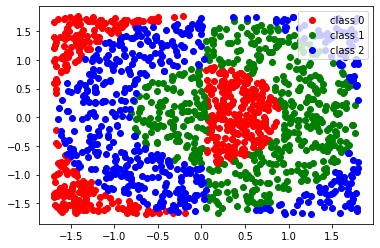

In [11]:
plt.figure()
uniques = np.unique(y[:, 0])
colors = ['r', 'g', 'b']
legend = []
for i in range(len(uniques)):
    ax = x[:, 0][y[:, 0] == uniques[i]]
    ay = x[:, 1][y[:, 0] == uniques[i]]
    plt.plot(ax, ay, colors[i] + 'o')
    legend.append('class ' + str(int(uniques[i])))
plt.legend(legend)
plt.show()

### Jedna warstwa ukryta

In [12]:
accuracy_sigmoid, network = train_network(x, y, [30], sigmoid, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_linear, network = train_network(x, y, [30], linear, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_tanh, network = train_network(x, y, [30], tanh, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_relu, network = train_network(x, y, [30], relu, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)

print(accuracy_sigmoid[-1])
print(accuracy_linear[-1])
print(accuracy_tanh[-1])
print(accuracy_relu[-1])

0.8473333333333334
0.4066666666666667
0.9313333333333333
0.9306666666666666


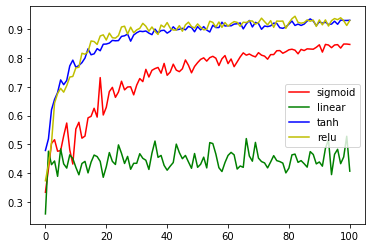

In [13]:
plt.figure()
plt.plot(accuracy_sigmoid, 'r')
plt.plot(accuracy_linear, 'g')
plt.plot(accuracy_tanh, 'b')
plt.plot(accuracy_relu, 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

### Dwie warstwy ukryte

In [16]:
accuracy_sigmoid, network = train_network(x, y, [30,20], sigmoid, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_linear, network = train_network(x, y, [30,20], linear, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_tanh, network = train_network(x, y, [30,20], tanh, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_relu, network = train_network(x, y, [30,20], relu, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)

print(accuracy_sigmoid[-1])
print(accuracy_linear[-1])
print(accuracy_tanh[-1])
print(accuracy_relu[-1])

0.9326666666666666
0.42866666666666664
0.9273333333333333
0.9553333333333334


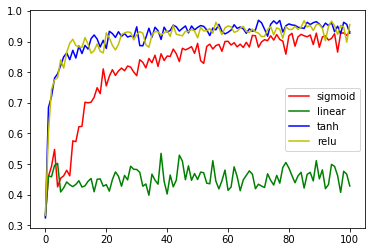

In [17]:
plt.figure()
plt.plot(accuracy_sigmoid, 'r')
plt.plot(accuracy_linear, 'g')
plt.plot(accuracy_tanh, 'b')
plt.plot(accuracy_relu, 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

### Trzy warstwy ukryte

In [14]:
accuracy_sigmoid, network = train_network(x, y, [30,20,10], sigmoid, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_linear, network = train_network(x, y, [30,20,10], linear, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_tanh, network = train_network(x, y, [30,20,10], tanh, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_relu, network = train_network(x, y, [30,20,10], relu, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)

print(accuracy_sigmoid[-1])
print(accuracy_linear[-1])
print(accuracy_tanh[-1])
print(accuracy_relu[-1])

0.924
0.4266666666666667
0.9693333333333334
0.9426666666666667


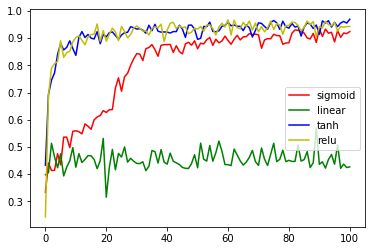

In [15]:
plt.figure()
plt.plot(accuracy_sigmoid, 'r')
plt.plot(accuracy_linear, 'g')
plt.plot(accuracy_tanh, 'b')
plt.plot(accuracy_relu, 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

## rings5-regular

In [70]:
train = read_data(file='mio1/classification/rings5-regular-training.csv', classification=True)
x,y = split_data(train, 2)
x = scale(x)

### Wizualizacja danych

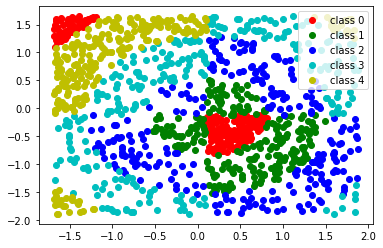

In [19]:
plt.figure()
uniques = np.unique(y[:, 0])
colors = ['r', 'g', 'b', 'c', 'y']
legend = []
for i in range(len(uniques)): 
    ax = x[:, 0][y[:, 0] == uniques[i]]
    ay = x[:, 1][y[:, 0] == uniques[i]]
    plt.plot(ax, ay, colors[i] + 'o')
    legend.append('class ' + str(int(uniques[i])))
plt.legend(legend)
plt.show()

### Jedna warstwa ukryta

In [20]:
accuracy_sigmoid, network = train_network(x, y, [30], sigmoid, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_linear, network = train_network(x, y, [30], linear, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_tanh, network = train_network(x, y, [30], tanh, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_relu, network = train_network(x, y, [30], relu, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)

print(accuracy_sigmoid[-1])
print(accuracy_linear[-1])
print(accuracy_tanh[-1])
print(accuracy_relu[-1])

0.8256
0.4696
0.9024
0.8688


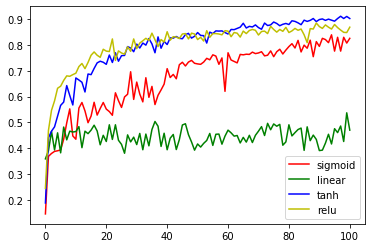

In [21]:
plt.figure()
plt.plot(accuracy_sigmoid, 'r')
plt.plot(accuracy_linear, 'g')
plt.plot(accuracy_tanh, 'b')
plt.plot(accuracy_relu, 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

### Dwie warstwy ukryte

In [22]:
accuracy_sigmoid, network = train_network(x, y, [30,20], sigmoid, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_linear, network = train_network(x, y, [30,20], linear, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_tanh, network = train_network(x, y, [30,20], tanh, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_relu, network = train_network(x, y, [30,20], relu, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)

print(accuracy_sigmoid[-1])
print(accuracy_linear[-1])
print(accuracy_tanh[-1])
print(accuracy_relu[-1])

0.8792
0.42
0.9584
0.944


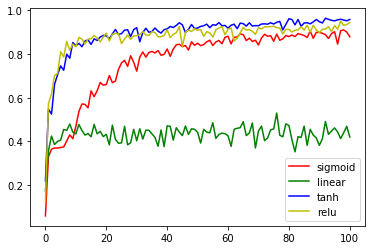

In [23]:
plt.figure()
plt.plot(accuracy_sigmoid, 'r')
plt.plot(accuracy_linear, 'g')
plt.plot(accuracy_tanh, 'b')
plt.plot(accuracy_relu, 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

### Trzy warstwy ukryte

In [24]:
accuracy_sigmoid, network = train_network(x, y, [30,20,10], sigmoid, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_linear, network = train_network(x, y, [30,20,10], linear, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_tanh, network = train_network(x, y, [30,20,10], tanh, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)
accuracy_relu, network = train_network(x, y, [30,20,10], relu, softmax, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=False)

print(accuracy_sigmoid[-1])
print(accuracy_linear[-1])
print(accuracy_tanh[-1])
print(accuracy_relu[-1])

0.916
0.4384
0.9416
0.944


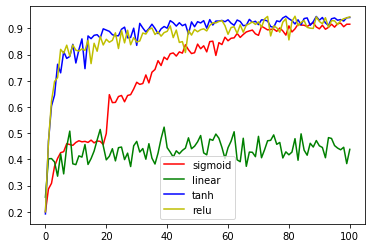

In [25]:
plt.figure()
plt.plot(accuracy_sigmoid, 'r')
plt.plot(accuracy_linear, 'g')
plt.plot(accuracy_tanh, 'b')
plt.plot(accuracy_relu, 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

## steps-large

In [71]:
train = read_data(file='mio1/regression/steps-large-training.csv', classification=False)
train = scale(train)
x,y = split_data(train, 1)

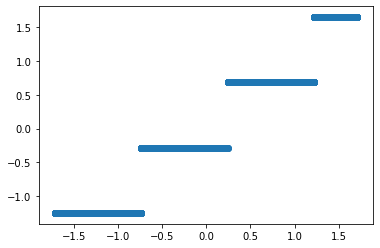

In [67]:
plt.figure()
plt.scatter(x,y)
plt.show()

### Jedna warstwa ukryta

In [36]:
mse_sigmoid, network = train_network(x, y, [30], sigmoid, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_linear, network = train_network(x, y, [30], linear, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_tanh, network = train_network(x, y, [30], tanh, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_relu, network = train_network(x, y, [30], relu, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)

print(mse_sigmoid[-1])
print(mse_linear[-1])
print(mse_tanh[-1])
print(mse_relu[-1])

0.02352649677942366
0.09176201362285571
0.03711587213787439
0.02479902933302687


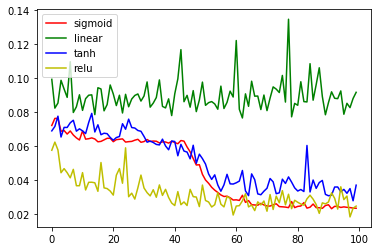

In [37]:
plt.figure()
plt.plot(mse_sigmoid[1:], 'r')
plt.plot(mse_linear[1:], 'g')
plt.plot(mse_tanh[1:], 'b')
plt.plot(mse_relu[1:], 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

### Dwie warstwy ukryte

In [38]:
mse_sigmoid, network = train_network(x, y, [30,20], sigmoid, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_linear, network = train_network(x, y, [30,20], linear, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_tanh, network = train_network(x, y, [30,20], tanh, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_relu, network = train_network(x, y, [30,20], relu, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)

print(mse_sigmoid[-1])
print(mse_linear[-1])
print(mse_tanh[-1])
print(mse_relu[-1])

0.00820643354641545
0.08232303899460885
0.005478594751149095
0.013658232191389886


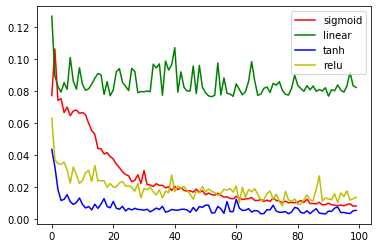

In [39]:
plt.figure()
plt.plot(mse_sigmoid[1:], 'r')
plt.plot(mse_linear[1:], 'g')
plt.plot(mse_tanh[1:], 'b')
plt.plot(mse_relu[1:], 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

### Trzy warstwy ukryte

In [73]:
mse_sigmoid, network = train_network(x, y, [30,20,10], sigmoid, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_linear, network = train_network(x, y, [30,20,10], linear, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_tanh, network = train_network(x, y, [30,20,10], tanh, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_relu, network = train_network(x, y, [30,20,10], relu, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)

print(mse_sigmoid[-1])
print(mse_linear[-1])
print(mse_tanh[-1])
print(mse_relu[-1])

0.004839554194433165
0.07756207652338971
0.004584008778850768
0.006507100811199115


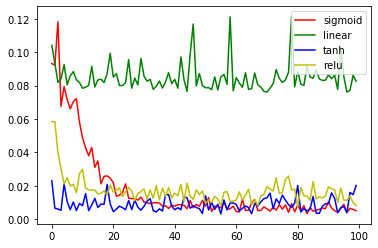

In [41]:
plt.figure()
plt.plot(mse_sigmoid[1:], 'r')
plt.plot(mse_linear[1:], 'g')
plt.plot(mse_tanh[1:], 'b')
plt.plot(mse_relu[1:], 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

### Wizualizacja przykładowej predykcji

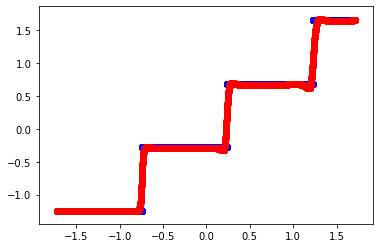

In [94]:
mse_sigmoid, network = train_network(x, y, [30,20,10], sigmoid, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
y_pred = network.forward(x)
plt.figure()
plt.scatter(x,y, c='b')
plt.scatter(x,y_pred, c='r')
plt.show()

## multimodal-large

In [59]:
train = read_data(file='mio1/regression/multimodal-large-training.csv', classification=False)
train = scale(train)
x,y = split_data(train, 1)

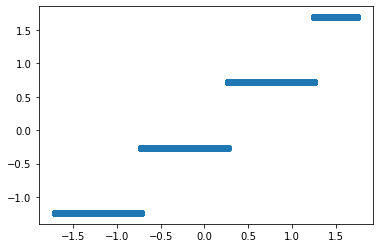

In [61]:
plt.figure()
plt.scatter(x,y)
plt.show()

### Jedna warstwa ukryta

In [43]:
mse_sigmoid, network = train_network(x, y, [30], sigmoid, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_linear, network = train_network(x, y, [30], linear, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_tanh, network = train_network(x, y, [30], tanh, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_relu, network = train_network(x, y, [30], relu, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)

print(mse_sigmoid[-1])
print(mse_linear[-1])
print(mse_tanh[-1])
print(mse_relu[-1])

0.018463068034467015
0.08187168446026072
0.03767399104386567
0.02877520076735166


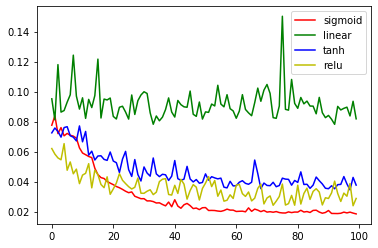

In [44]:
plt.figure()
plt.plot(mse_sigmoid[1:], 'r')
plt.plot(mse_linear[1:], 'g')
plt.plot(mse_tanh[1:], 'b')
plt.plot(mse_relu[1:], 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

### Dwie warstwy ukryte

In [45]:
mse_sigmoid, network = train_network(x, y, [30,20], sigmoid, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_linear, network = train_network(x, y, [30,20], linear, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_tanh, network = train_network(x, y, [30,20], tanh, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_relu, network = train_network(x, y, [30,20], relu, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)

print(mse_sigmoid[-1])
print(mse_linear[-1])
print(mse_tanh[-1])
print(mse_relu[-1])

0.007920235751447732
0.0844951232561143
0.007645219110733633
0.010977638334220882


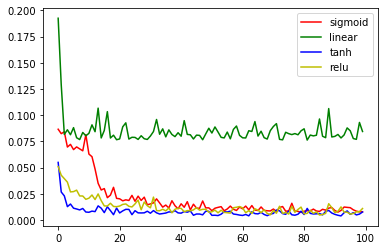

In [46]:
plt.figure()
plt.plot(mse_sigmoid[1:], 'r')
plt.plot(mse_linear[1:], 'g')
plt.plot(mse_tanh[1:], 'b')
plt.plot(mse_relu[1:], 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

### Trzy warstwy ukryte

In [47]:
mse_sigmoid, network = train_network(x, y, [30,20,10], sigmoid, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_linear, network = train_network(x, y, [30,20,10], linear, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_tanh, network = train_network(x, y, [30,20,10], tanh, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)
mse_relu, network = train_network(x, y, [30,20,10], relu, linear, beta=0.9, alpha=0.01, n_epochs=1, n_iter=100, regression=True)

print(mse_sigmoid[-1])
print(mse_linear[-1])
print(mse_tanh[-1])
print(mse_relu[-1])

0.008324209778011252
0.07947200077347759
0.008781689342486184
0.007093490023557486


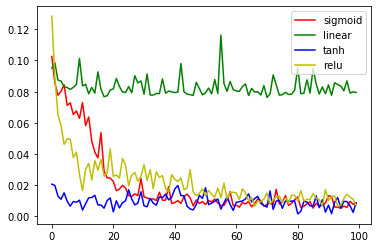

In [48]:
plt.figure()
plt.plot(mse_sigmoid[1:], 'r')
plt.plot(mse_linear[1:], 'g')
plt.plot(mse_tanh[1:], 'b')
plt.plot(mse_relu[1:], 'y')
legend = ['sigmoid', 'linear', 'tanh', 'relu']
plt.legend(legend)
plt.show()

## Wnioski

Dla klasyfikacji najlepiej (najwyższe accuracy) wychodzą predykcje z funkcją aktywacji tanh oraz relu (wyniki porównywalne), dalej jest sigmoid, a najgorzej wypada funkcja liniowa.

Dla regresji z dwiema lub trzema warstwami ukrytymi najlepiej (najniższe mse) wychodzą predykcje z funkcją aktywacji tanh, kolejne to relu, sigmoid i liniowa.
Dla regresji z jedną warstwą ukrytą: relu, sigmoid, tanh, liniowa.